In [3]:
import os
os.environ['SM_FRAMEWORK'] = 'tf.keras'

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

In [51]:
# resizing all the images
IMAGE_SIZE = (100,100)
path = '/Users/sahreenhaider/Downloads/New_Data_CoV2'
data = []

In [52]:
def data_loader():
  main_folder = 0
  folder = 0
  sub_folder = 0
  c = 0
  try:
    for folder in os.listdir(path):
      try:
        sub_path=path+"/"+folder
        for folder2 in os.listdir(sub_path):
          try:
            sub_path2=sub_path+"/"+folder2
            for img in os.listdir(sub_path2):
              image_path=sub_path2+"/"+img
              img_arr=cv2.imread(image_path)
              img_arr=cv2.resize(img_arr,IMAGE_SIZE)
              data.append(img_arr)
          except Exception as E:
            c+=1
      except Exception as E:
        sub_folder += 1
  except Exception as E:
    main_folder += 1   

In [53]:
data_loader()

In [54]:
# converting the data list consisting of arrays into an array
X = np.array(data)

In [55]:
# shape of X
X.shape

(4171, 100, 100, 3)

In [56]:
# normalizing the input
x = X/255

In [57]:
# using datagen to agument the existing input data to make the prediction labels
datagen = ImageDataGenerator(rescale = 1/255)
dataset = datagen.flow_from_directory(path,
                                    target_size = IMAGE_SIZE,
                                    batch_size = 32,
                                    class_mode = 'sparse')

Found 4171 images belonging to 3 classes.


In [58]:
# classes of predict labels
dataset.class_indices

{'Covid': 0, 'Healthy': 1, 'Others': 2}

In [59]:
y = dataset.classes

In [60]:
y.shape

(4171,)

In [61]:
x.shape

(4171, 100, 100, 3)

In [62]:
# splitting the data into train, validation, test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)

In [63]:
x_train.shape, y_train.shape

((3002, 100, 100, 3), (3002,))

In [64]:
x_val.shape, y_val.shape

((751, 100, 100, 3), (751,))

In [65]:
x_test.shape, y_test.shape

((418, 100, 100, 3), (418,))

In [66]:
x_train[0].shape

(100, 100, 3)

In [4]:
from tensorflow._api.v2.nn import dropout
model = tf.keras.Sequential()

# convoltuion layer
model.add(tf.keras.layers.Conv2D(32, (3,3), activation = tf.nn.relu, input_shape = x_train[0].shape))
# pooling layer
model.add(tf.keras.layers.MaxPool2D(2,2))
model.add(tf.keras.layers.BatchNormalization())


# convolution layer
model.add(tf.keras.layers.Conv2D(32, (3,3), activation = tf.nn.relu))
# pooling layer
model.add(tf.keras.layers.MaxPool2D(2,2))
model.add(tf.keras.layers.BatchNormalization())

# convolution layer
model.add(tf.keras.layers.Conv2D(64, (3,3), activation = tf.nn.relu))
# pooling layer
model.add(tf.keras.layers.MaxPool2D(2,2))
model.add(tf.keras.layers.BatchNormalization())

# convolution layer
model.add(tf.keras.layers.Conv2D(64, (3,3), activation = tf.nn.relu))
# pooling layer
model.add(tf.keras.layers.MaxPool2D(2,2))
model.add(tf.keras.layers.BatchNormalization())

# input layer
model.add(tf.keras.layers.Flatten())


# output layer
model.add(tf.keras.layers.Dense(3, activation = tf.nn.softmax))

model.summary()

NameError: name 'x_train' is not defined

In [68]:
# compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [69]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, start_from_epoch = 7, patience=5)

In [70]:
record = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=50, callbacks=[early_stop], shuffle=True)

Epoch 1/50
94/94 [==============================] - 92s 911ms/step - loss: 0.9827 - accuracy: 0.5733 - val_loss: 1.8661 - val_accuracy: 0.2823
Epoch 2/50
94/94 [==============================] - 82s 876ms/step - loss: 0.6598 - accuracy: 0.7255 - val_loss: 2.4997 - val_accuracy: 0.2823
Epoch 3/50
94/94 [==============================] - 78s 827ms/step - loss: 0.4965 - accuracy: 0.8125 - val_loss: 1.5831 - val_accuracy: 0.2836
Epoch 4/50
94/94 [==============================] - 86s 913ms/step - loss: 0.3856 - accuracy: 0.8578 - val_loss: 1.2338 - val_accuracy: 0.4527
Epoch 5/50
94/94 [==============================] - 85s 907ms/step - loss: 0.2726 - accuracy: 0.9107 - val_loss: 1.4281 - val_accuracy: 0.4501
Epoch 6/50
94/94 [==============================] - 75s 796ms/step - loss: 0.1840 - accuracy: 0.9464 - val_loss: 0.7833 - val_accuracy: 0.6831
Epoch 7/50
94/94 [==============================] - 70s 748ms/step - loss: 0.0998 - accuracy: 0.9813 - val_loss: 1.1486 - val_accuracy: 0.5686

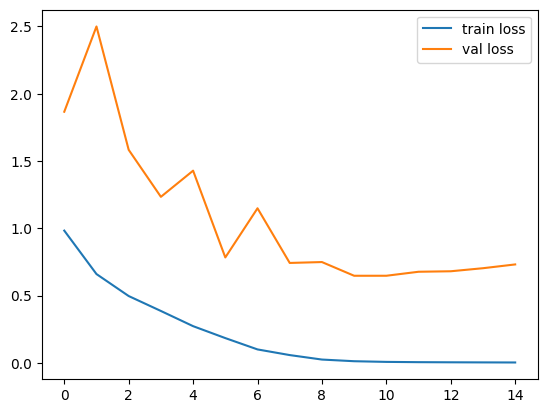

In [71]:
plt.plot(record.history['loss'], label = 'train loss')
plt.plot(record.history['val_loss'], label = 'val loss')
plt.legend()

plt.savefig('loss_graph.png')
plt.show()

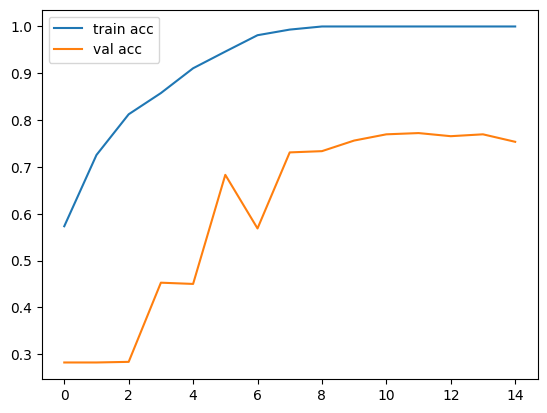

In [72]:
# accuracy over epochs
plt.plot(record.history['accuracy'], label = 'train acc')
plt.plot(record.history['val_accuracy'], label = 'val acc')
plt.legend()
plt.savefig('acc-graph.png')
plt.show()

In [73]:
y_val_pred = model.predict(x_val)
y_val_pred = np.argmax(y_val_pred, axis=1)
print(classification_report(y_val_pred, y_val))

24/24 [==============================] - 8s 248ms/step
              precision    recall  f1-score   support

           0       0.91      0.80      0.85       454
           1       0.48      0.66      0.55       102
           2       0.64      0.70      0.67       195

    accuracy                           0.75       751
   macro avg       0.68      0.72      0.69       751
weighted avg       0.78      0.75      0.76       751



In [74]:
confusion_matrix(y_val_pred, y_val)

array([[363,  41,  50],
       [  9,  67,  26],
       [ 26,  33, 136]])

In [75]:
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis = 1)

14/14 [==============================] - 4s 294ms/step


In [76]:
accuracy_score(y_pred, y_test)

0.7727272727272727

In [77]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.93      0.80      0.86       252
           1       0.53      0.75      0.62        55
           2       0.65      0.72      0.68       111

    accuracy                           0.77       418
   macro avg       0.70      0.76      0.72       418
weighted avg       0.80      0.77      0.78       418



In [78]:
confusion_matrix(y_pred, y_test)

array([[202,  18,  32],
       [  3,  41,  11],
       [ 13,  18,  80]])

In [106]:
accuracy_score(train_pred, y_train)

NameError: name 'accuracy_score' is not defined

In [ ]:
model.to_json('/Users/sahreenhaider/Documents/Covid_detection_model/model.json')

In [83]:
model.save('/Users/sahreenhaider/Documents/Covid_detection_model/model.h5')